## Install and import

In [1]:
!pip install torch==1.4.0
!pip install transformers==2.11.0
!pip install attrdict==2.0.1

     |████████████████████████████████| 753.4MB 19kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
     |████████████████████████████████| 675kB 5.8MB/s 
     |████████████████████████████████| 1.2MB 9.3MB/s 
     |████████████████████████████████| 5.6MB 18.3MB/s 
     |████████████████████████████████| 870kB 41.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=0077b3f47abdf8af8544326942cf9eaf581dedf65e4639ef9b1fde96999cd627
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [1]:
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel
from transformers import BertTokenizer
from typing import Union, Optional

import numpy as np
from transformers.pipelines import ArgumentHandler
from transformers import (
    Pipeline,
    PreTrainedTokenizer,
    ModelCard
)
from pprint import pprint
import os
import google.colab as colab
import pandas as pd
import json
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

In [7]:
def mount_google_drive():
	'''
	# Functionality
		Mount google drive. Since colab does not save files, we want to make it easier to directly access files in google drive.
	# Arguments
		Nothing
	# Returns
		drive_root: the working directory mounted
	'''
	mount_directory = "/content/gdrive"
	drive = colab.drive
	drive.mount(mount_directory, force_remount=True)
	drive_root = mount_directory + "/" + list(filter(lambda x: x[0] != '.', os.listdir(mount_directory)))[0]
	return drive_root

ROOT_DIR =  mount_google_drive() + "/goemotion/"
CHECKPOINT_ROOT = ROOT_DIR+ "goemotion-ckpt/original/checkpoint-10000"

Mounted at /content/gdrive


## Model Class

In [8]:
class BertForMultiLabelClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.loss_fct = nn.BCEWithLogitsLoss()

        self.init_weights()

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            position_ids=None,
            head_mask=None,
            inputs_embeds=None,
            labels=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            loss = self.loss_fct(logits, labels)
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

## Multi-label inference pipeline

In [9]:
class MultiLabelPipeline(Pipeline):
    def __init__(
            self,
            model: Union["PreTrainedModel", "TFPreTrainedModel"],
            tokenizer: PreTrainedTokenizer,
            modelcard: Optional[ModelCard] = None,
            framework: Optional[str] = None,
            task: str = "",
            args_parser: ArgumentHandler = None,
            device: int = -1,
            binary_output: bool = False,
            threshold: float = 0.3
    ):
        super().__init__(
            model=model,
            tokenizer=tokenizer,
            modelcard=modelcard,
            framework=framework,
            args_parser=args_parser,
            device=device,
            binary_output=binary_output,
            task=task
        )

        self.threshold = threshold

    def __call__(self, *args, **kwargs):
        outputs = super().__call__(*args, **kwargs)
        scores = 1 / (1 + np.exp(-outputs))  # Sigmoid
        results = []
        for item in scores:
            labels = []
            scores = []
            for idx, s in enumerate(item):
                if s > self.threshold:
                    labels.append(self.model.config.id2label[idx])
                    scores.append(float(s))
            results.append({"labels": labels, "scores": scores})
        return results

## Inference On Testset

In [10]:
tokenizer = BertTokenizer.from_pretrained(CHECKPOINT_ROOT)
model = BertForMultiLabelClassification.from_pretrained(CHECKPOINT_ROOT)

goemotions = MultiLabelPipeline(
    model=model,
    tokenizer=tokenizer,
    threshold=0.3
)

texts = [
    "Hey that's a thought! Maybe we need [NAME] to be the celebrity vaccine endorsement!",
    "it’s happened before?! love my hometown of beautiful new ken 😂😂",
    "I love you, brother.",
    "Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit",
]

pprint(goemotions(texts))

# Output
#  [{'labels': ['neutral'], 'scores': [0.9750906]},
#  {'labels': ['curiosity', 'love'], 'scores': [0.9694574, 0.9227462]},
#  {'labels': ['love'], 'scores': [0.993483]},
#  {'labels': ['anger'], 'scores': [0.99225825]}]

[{'labels': ['optimism'], 'scores': [0.32062143087387085]},
 {'labels': ['curiosity', 'love'],
  'scores': [0.412200003862381, 0.8766248226165771]},
 {'labels': ['love'], 'scores': [0.9667580723762512]},
 {'labels': ['anger'], 'scores': [0.9185698628425598]}]


## Load Test set and true labels

In [11]:
# Load labels and build dicts
with open(ROOT_DIR + "data/original/labels.txt", "r") as f:
  labels = f.read().splitlines()
label2index = {v: k for k, v in enumerate(labels)}
index2label = {k: v for k, v in enumerate(labels)}


# Load test set, get test sents and ground truths
df = pd.read_csv(ROOT_DIR + "data/original/test.tsv", sep='\t', header=None, names=["sentence", "label", "encoding"])
sentences = df.sentence.tolist()
ground_truths = []
for x in df.label.tolist():
  single_idxs = x.split(",")
  single_labels = []
  for label in single_idxs:
    single_labels.append(index2label[int(label)])
  ground_truths.append(single_labels)

In [13]:
raw_predictions = []
batch_size = 81
num_batches = len(sentences) / batch_size

i = 0
while i < len(sentences):
  raw_predictions += goemotions(sentences[i: i + batch_size])
  i = i + batch_size

with open(ROOT_DIR + "data/original/predictions_epoch4.json", 'w') as f:
  json.dump(raw_predictions, f)

In [14]:
with open(ROOT_DIR + "data/original/predictions_epoch4.json", 'r') as f:
  raw_predictions = json.load(f)

In [15]:
predictions = [x["labels"] for x in raw_predictions]

In [16]:
len(ground_truths) == len(predictions)

True

In [17]:
num_em = 0
for i, (pred, truth) in enumerate(zip(predictions, ground_truths)):
  if pred == truth:
    num_em += 1
print(num_em / len(predictions))

0.4300718629076838


In [18]:
def convert_onehot(inputs):
  final_arr = np.zeros((len(inputs), len(label2index.keys())))
  for i, labels in enumerate(inputs):
    for label in labels:
      final_arr[i, label2index[label]] = 1
  return final_arr

In [19]:
onehot_truths = convert_onehot(ground_truths)
onehot_preds = convert_onehot(predictions)

In [20]:
multilabel_confmat = multilabel_confusion_matrix(onehot_truths, onehot_preds)

In [37]:
cls_report = {}
for i in range(multilabel_confmat.shape[0]):
  cls_report[index2label[i]] = {}
  cls_report[index2label[i]]["tn"] = multilabel_confmat[i, 0, 0] + 1
  cls_report[index2label[i]]["fp"] = multilabel_confmat[i, 0, 1] + 1
  cls_report[index2label[i]]["fn"] = multilabel_confmat[i, 1, 0] + 1
  cls_report[index2label[i]]["tp"] = multilabel_confmat[i, 1, 1] + 1
  cls_report[index2label[i]]["total"] = cls_report[index2label[i]]["tp"] + cls_report[index2label[i]]["fn"]
  cls_report[index2label[i]]["precision"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fp"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["recall"] = cls_report[index2label[i]]["tp"] / (cls_report[index2label[i]]["fn"] + cls_report[index2label[i]]["tp"])
  cls_report[index2label[i]]["f1"] = 2 * cls_report[index2label[i]]["precision"] * cls_report[index2label[i]]["recall"] / (cls_report[index2label[i]]["precision"] + cls_report[index2label[i]]["recall"])

In [38]:
# Make a plot of the distribution of classes
cls_report

{'admiration': {'f1': 0.6654867256637168,
  'fn': 130,
  'fp': 248,
  'precision': 0.6025641025641025,
  'recall': 0.7430830039525692,
  'tn': 4677,
  'total': 506,
  'tp': 376},
 'amusement': {'f1': 0.8074957410562181,
  'fn': 29,
  'fp': 84,
  'precision': 0.7383177570093458,
  'recall': 0.8909774436090225,
  'tn': 5081,
  'total': 266,
  'tp': 237},
 'anger': {'f1': 0.5058548009367682,
  'fn': 92,
  'fp': 119,
  'precision': 0.47577092511013214,
  'recall': 0.54,
  'tn': 5112,
  'total': 200,
  'tp': 108},
 'annoyance': {'f1': 0.36962750716332377,
  'fn': 193,
  'fp': 247,
  'precision': 0.34308510638297873,
  'recall': 0.40062111801242234,
  'tn': 4862,
  'total': 322,
  'tp': 129},
 'approval': {'f1': 0.3925729442970822,
  'fn': 205,
  'fp': 253,
  'precision': 0.3690773067331671,
  'recall': 0.4192634560906516,
  'tn': 4825,
  'total': 353,
  'tp': 148},
 'caring': {'f1': 0.4429065743944636,
  'fn': 73,
  'fp': 88,
  'precision': 0.42105263157894735,
  'recall': 0.467153284671532

In [30]:
def get_attr_class(cls_report, metric_name):
  return [x[metric_name] for x in list(cls_report.values())]


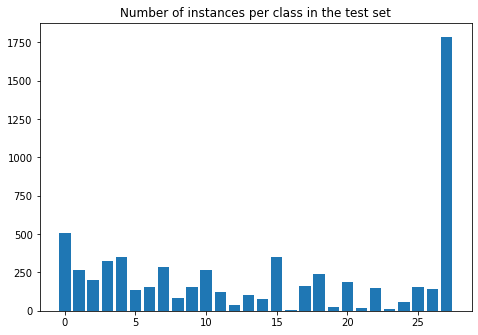

In [39]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of instances per class in the test set')
metric_name = "total"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()

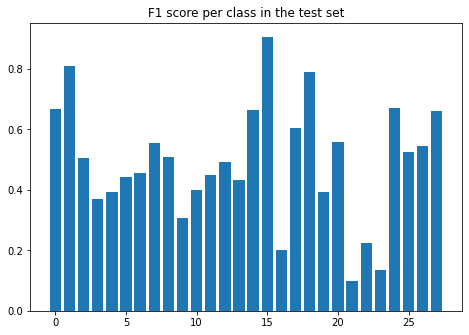

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('F1 score per class in the test set')
metric_name = "f1"
ax.bar(list(label2index.values()), [x[metric_name] for x in list(cls_report.values())])
plt.show()